In [14]:
import numpy as np
from pandas import Series,DataFrame
import pandas as pd

# scipyの統計パッケージも使います。
from scipy import stats

# 描画のためのライブラリです。
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ブラウザ内に画像を埋め込むための命令です
%matplotlib inline

In [15]:
#データの読み込み
df = pd.read_table('UKdriversKSI.txt', skiprows=1, header=None)
df.columns = ['KSI']
df['logKSI'] = np.log(df['KSI'])
df['t'] = np.arange(len(df))+1

df.head()

,KSI,logKSI,t
0,1687,7.430707,1
1,1508,7.318540,2
2,1507,7.317876,3
3,1385,7.233455,4
4,1632,7.397562,5


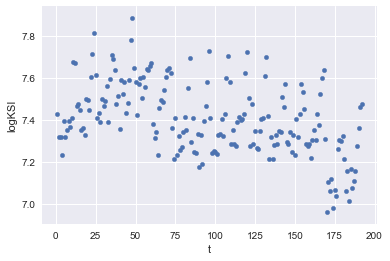

In [16]:
#データを表示する
df.plot(kind='scatter',x='t',y='logKSI')

このデータは、(月次)時間に対する英国ドライバーの死傷者数の対数を示したものである。
これからこのデータを用いて、状態空間法に関する学習を進めていく。

# 古典的回帰分析
まず初めに、古典的回帰分析によるデータの説明を行う。
古典的回帰分析では、従属変数$y$と、独立変数$x$の間で線型性を仮定する。
この関係からの偏差は、ゼロを中心化した確率過程(定義は後)から生じると仮定する。  
$y$($y_i,i=1...n$で表す)と$x$($x_i,i=1...n$で表す)の$n$個の観測値から成る標準回帰モデルは、次のように書くことができる。

$y_i=a+bx_i+\epsilon_i,   \epsilon_i \sim NID(0,{\sigma_\epsilon}^2)$

ここで、$\epsilon_i \sim NID(0,{\sigma_\epsilon}^2)$は、残差$\epsilon_i$が、平均がゼロで、
分散が$\sigma_\epsilon^2$の正規で、独立な分布に従うという仮定を示している。この標準回帰モデルにより先のデータが表すことができるかを試してみよう。ここでは、pythonのstatsmodelsを使って計算を行う。

In [137]:
#statsmodelsのインポート
import statsmodels.formula.api as smf

# モデルを作成する
lm = smf.ols(formula='logKSI ~ t', data=df).fit()

# パラメータa,bを表示する
lm.params

Intercept    7.545843
t           -0.001448
dtype: float64

以上のように、statsmodelsを使うことで、標準回帰モデルの係数$a,b$を計算することができる。
次に、このモデルの結果を、元のデータに重ね合わせてみる。

In [25]:
#標準回帰モデルの出力を、新たな列に加える
df['regression line'] = lm.predict()

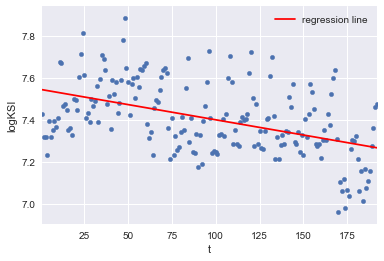

In [32]:
#データをプロットする
fig, ax = plt.subplots(1,1)
df.plot(kind='scatter',x='t',y='logKSI',ax=ax)
df.plot(x='t',y='regression line', c='red',ax=ax)

さて、この標準回帰モデルの当てはまりについて考察する。このモデル誤差分散
$\check{\sigma}_\epsilon^2$は

In [51]:
lm.scale

0.022998056021100406

である[1]。また、当てはまりの良さに対する標準的なFテストは

In [54]:
lm.fvalue

53.774465523177362

In [55]:
lm.f_pvalue

6.3132371722560616e-12

となり、基準変数$x$と予測変数$y$の間の線形関係は高度に有意である。  
この分析でわかったことは、「時間がドライバーの死傷者数の対数の優位な予測変数である」
ということである。これらの2つの変数間には負の相関がある。しかし、本当にこのモデルが正しいのだろうか。
モデルでは、$y-a-bx$は、互いに独立となることを仮定しているが、この例ではそうならない。具体的にデータを見てみよう。


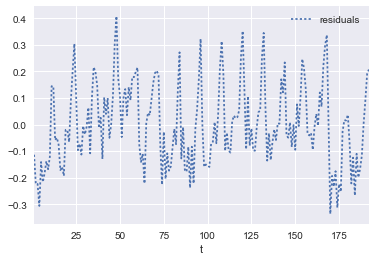

In [61]:
#モデルの残差信号
df['residuals'] = lm.resid
df.plot(x='t',y='residuals',style=':')

上図のように、残差信号はランダムに散らばっていない。
標準回帰モデルでは、残差信号はランダムであることを仮定しているのにも関わらず!  
1組の観測値がランダムであることを調べる有効な診断法はコレログラム(correlogram)である。


(-1, 1)

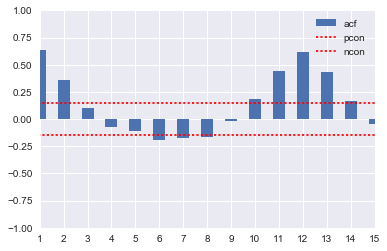

In [144]:
from statsmodels.tsa.stattools import acf
df_acf = pd.DataFrame(acf(df['residuals'],nlags=15),columns = ['acf'])

#ホワイトノイズの95%信頼区間 [2]の3.4を参照して下さい
confi  = 2/np.sqrt(len(df))
df_acf['pcon'] =  confi*np.ones(len(df_acf))
df_acf['ncon'] = -confi*np.ones(len(df_acf))

fig, ax = plt.subplots(1,1)
df_acf.plot(y='acf',kind='bar',ax=ax)
df_acf.plot(y='pcon',style=':',ax=ax,c='red')
df_acf.plot(y='ncon',style=':',ax=ax,c='red')
plt.xlim(1,15)
plt.ylim(-1,1)

上のように、コレログラムが優位にゼロと異なる多くの自己相関を含むことから、モデルの誤差はランダムとは言い難い。
すなわち、標準回帰モデルにより、KSIは説明不能であることがわかる。  
参考までに、乱数列のコレログラムも書いてみる。


(-1, 1)

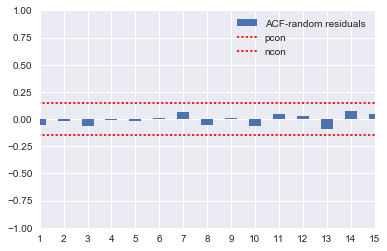

In [139]:
from numpy.random import randn

# 乱数列を作成する
rn = randn(len(df))

# 乱数列のコレログラムを作成する
df_acf['ACF-random residuals'] = acf(rn,nlags=15)

# 描画を行う
fig, ax = plt.subplots(1,1)
df_acf.plot(y='ACF-random residuals',kind='bar',ax=ax)
df_acf.plot(y='pcon',style=':',ax=ax,c='red')
df_acf.plot(y='ncon',style=':',ax=ax,c='red')
plt.xlim(1,15)
plt.ylim(-1,1)

このように、乱数列のコレログラムは、ゼロに近い値が現れ、全て95%信頼区間以内に存在する。

# 参考文献
[1] http://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.RegressionResults.html
[2]http://shadow.eas.gatech.edu/~jean/paleo/Meko_Autocorrelation.pdf
